In [1]:
from scarp import model, help_func
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
np.random.seed(1)
random_state = 1


# 0. Preparing your scATAC-seq data in h5ad format

In [2]:
data_name = 'Leukemia'
data = sc.read_h5ad('../Example_data/Leukemia.h5ad')

In [3]:
data

AnnData object with n_obs × n_vars = 391 × 7602
    obs: 'celltype'

In [4]:
Cells = data.obs.index
Cells_num, Peaks_num = data.X.shape
N = Cells_num + Peaks_num
labels = data.obs['celltype'].astype('category')
cluster_num = np.unique(labels).shape[0]
print('Number of Peaks:', Peaks_num)
print('Number of Cells:', Cells_num)
print('Number of labels: ', cluster_num)

Number of Peaks: 7602
Number of Cells: 391
Number of labels:  6


# 1. Running SCARP easily in one step

#### parameter descriptions:
 parameter name | description                                          | type           | default 
 :------------- | :--------------------------------------------------- | :------------- | :------ 
 adata          | input scATAC-seq data                                | h5ad           | None    
 data_name          | name of this dataset                                | str           | None    
 m              | parameter to control NR diffusion intensity                      | float          | 1.5     
 gamma     |  parameter to control the threshold for merging adjacent chromosomes            | int            | 3000    
 beta           | parameter to control the extent to which prior edge weight decays | int          | 5000     
 return_shape   | shape of the returned matrix                            | str            | 'CN'    
 peak_loc       | use peak location prior information or not                          | bool            | True    
 parallel       | parallel computing or not. 0 means automatically determined                         | int            | 0       
 plot_SD       | plot the SDs of PCs or not                        | bool            | True   
fig_size       | figure size of the SD plot                     | tuple            | (4,3)   
save_file       | if plot_std is True, the file path you want to save                  | str            | None
verbose       | print the process or not                  | bool            | True


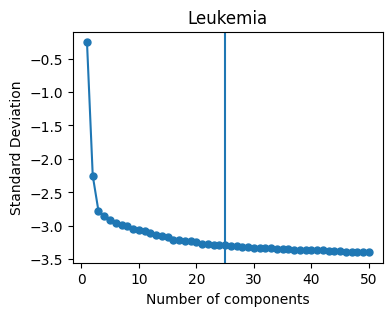

In [5]:
Cells_df = model.SCARP(adata=data,
                       data_name=data_name,
                       plot_SD=True,
                       verbose=False
                       )

In [6]:
Cells_df.head(5)

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25
BM1077_LMPP_Frozen_160107_1,0.753439,0.224301,-0.144794,0.062180,-0.084162,0.100960,0.066269,-0.158903,0.192439,0.318414,...,0.027570,-0.090796,-0.020819,-0.127398,0.008741,0.019934,0.056318,-0.145519,0.018745,-0.016860
BM1077_LMPP_Frozen_160107_2,0.937317,0.297376,-0.093136,0.012978,-0.040841,0.033291,0.043734,-0.027676,0.003704,-0.016802,...,0.010758,0.031346,0.013494,-0.042269,-0.025883,0.015085,0.016352,0.025123,0.001949,0.034107
BM1077_LMPP_Frozen_160107_3,0.862305,0.104204,-0.123610,-0.043276,-0.070724,-0.019920,0.051948,-0.088351,0.059365,0.151036,...,-0.059832,-0.185553,-0.093016,-0.097235,0.022417,0.118138,-0.132525,-0.049440,0.200076,0.132360
BM1077_LMPP_Frozen_160107_4,0.315740,0.182990,-0.170369,-0.057610,-0.023815,0.185537,0.190723,-0.061685,0.287947,0.537910,...,-0.065605,-0.023024,0.081820,0.298610,0.086558,-0.001907,0.015694,-0.020109,0.063611,0.042157
BM1077_LMPP_Frozen_160107_5,0.774632,0.322630,-0.143398,-0.032272,-0.066281,0.078476,0.083274,-0.033360,0.093270,0.300524,...,0.059730,-0.026439,0.017502,0.200632,0.074092,-0.156735,0.012141,0.001171,0.080175,0.001351



# 1. Running SCARP step by step

### (1) Obtaining the NR diffused matrix

In [7]:
t, diffusion_mat = model.SCARP_diffusion_mat(adata=data)


%%%%%%%%%%%%%%%%%%%%%%%% Diffusion Started (without parallel computing)%%%%%%%%%%%%%%%%%%%%%%%%%%
       ====================== Chr1~2: 1299 Peaks ========================
       ====================== Chr3~11: 3096 Peaks ========================
       ====================== Chr12~23: 3207 Peaks ========================
%%%%%%%%%%%%%%%%%%%%%%%%%%% Diffusion Finished %%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Running time: 5.250962734222412s

Matrix Splicing...........
Splicing time: 0.1129910945892334s


### (2) Computing the retained dimension

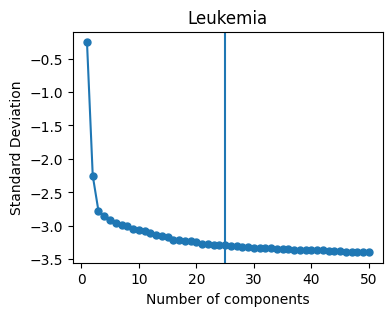

In [8]:
k = model.SCARP_SD_plot(data=diffusion_mat,
                        peaks_num=Peaks_num,
                        title=data_name,
                        plot_SD=True)

### (3) Dimensional reduction

In [9]:
Cell_embedding = model.SCARP_cell_embedding(diffusion_mat=diffusion_mat,
                                            kept_comp=k,
                                            Cells=Cells)


# 2. Unsupervised clustering of cells using Louvain

In [10]:
adata_cell = sc.AnnData(Cells_df)
adata_cell.var_names_make_unique()
adata_cell.obs['label'] = labels.astype(Category)

In [11]:
sc.pp.neighbors(adata_cell, use_rep='X', random_state=random_state)
sc.tl.umap(adata_cell, random_state=random_state)

[warning, adata_cell] = help_func.getNClusters_Louvain(adata_cell, cluster_num)

e:\Anaconda\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 3. Visualization & Evaluation

e:\Anaconda\envs\py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
e:\Anaconda\envs\py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
e:\Anaconda\envs\py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


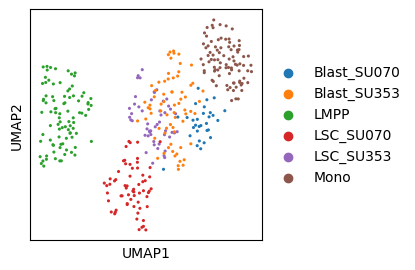

In [12]:
fig1, ax = plt.subplots(figsize=(3, 3))
sc.pl.umap(adata_cell, color='label', title='', s=20, ax=ax)

e:\Anaconda\envs\py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
e:\Anaconda\envs\py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
e:\Anaconda\envs\py310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


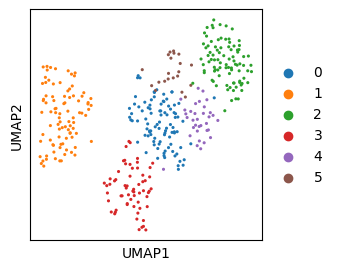

In [13]:
fig2, ax = plt.subplots(figsize=(3, 3))
sc.pl.umap(adata_cell, color='louvain', title='', s=20, ax=ax)

In [14]:
apart_mixed_label = adata_cell.obs['label']
apart_mixed_louvain = adata_cell.obs['louvain']
score = pd.DataFrame({'ARI': [adjusted_rand_score(apart_mixed_louvain, apart_mixed_label)],
                      'NMI': [normalized_mutual_info_score(apart_mixed_louvain, apart_mixed_label)]
                      },
                     index=['louvain'])
print(score)

              ARI       NMI
louvain  0.810485  0.838735
